In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from g2p_en import G2p
import re

from basicOperations.manifoldOperations import matrixDistance, frechetMean
import torch.nn.utils as utils

from rnn import euclideanRnn
import math

import pickle
import Levenshtein
import os

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
"""
Proof for table 1, figure 2, and figure 3.
"""

In [ ]:
"""
Train LARGE-VOCAB EMG-to-phoneme conversion.

For description of the data, please see largeVocabDataVisualization.ipynb

Unlike data SMALL-VOCAB, there are no timestamps between words within a sentence. 

Given a sentence, you decode it fully using CTC loss. The pipeline resembles standard speech-to-text (ASR) techniques.

This is a baseline method that uses spectrograms insted of SPD matrices.
"""

"""https://pypi.org/project/Levenshtein/ - install this Lev distance."""

In [2]:
"""
Open Data.
"""

with open("DATA/dataLargeVocab.pkl", "rb") as file:
    DATA = pickle.load(file)

with open("DATA/labelsLargeVocab.pkl", "rb") as file:
    LABELS = pickle.load(file)

In [3]:
"""
English phoneme definitions.
"""

PHONE_DEF = ['AO', 'OY', 'DH', 'ZH', 'SH', 'CH', 'UH', 'NG', 'IY', 'AA', 'W', 'S', 'IH', 'K', 'EY', 'JH', 'Y', 'N', 'OW', 'M', 'P', 'T', 'B', 'AY', 'UW', 'R', 'G', 'EH', 'Z', 'TH', 'AW', 
             'HH', 'AH', 'AE', 'L', 'ER', 'F', 'V', 'D', ' ', 'SIL']

def phoneToId(p):
    return PHONE_DEF.index(p)

g2p = G2p()

In [4]:
"""
Phonemize the sentences.
"""

phonemizedSentences = []

for i in range(len(LABELS)):
    phones = []
    for p in g2p(LABELS[i]): 
        p = re.sub(r'[0-9]', '', p)   
        if re.match(r'[A-Z]+', p) or p == " ": 
            phones.append(p)
    phonemizedSentences.append(phones)

In [5]:
"""
Convert phone-to-indices using look-up dictionary PHONE_DEF.
"""

phoneIndexedSentences = []
for i in range(len(phonemizedSentences)):
    current = phonemizedSentences[i]
    phoneID = []
    for j in range(len(current)):
        phoneID.append(phoneToId(current[j]))
    phoneIndexedSentences.append(phoneID)

In [6]:
"""
Pad the phone transcribed sentences to a common length (to be used with CTC loss).
"""

phonemizedLabels = np.zeros((len(phoneIndexedSentences), 76)) - 1
for i in range(len(phoneIndexedSentences)):
    phonemizedLabels[i, 0:len(phoneIndexedSentences[i])] = phoneIndexedSentences[i]

labelLengths = np.zeros((len(phoneIndexedSentences)))
for i in range(len(phoneIndexedSentences)):
    labelLengths[i] = len(phoneIndexedSentences[i])

In [7]:
"""
z-normalize the data along the time dimension.
"""

normDATA = []
for i in range(len(DATA)):
    Mean = np.mean(DATA[i], axis = -1)
    Std = np.std(DATA[i], axis = -1)
    normDATA.append((DATA[i] - Mean[..., np.newaxis])/Std[..., np.newaxis])

In [8]:
"""Create EMG spectrograms. Bin the frequencies into 31 bins (so that the neural netwrk size remains consistent with that 
of SPD matrices for fair comparison)."""

def spectrogramEmg(
    X: np.ndarray,                 
    fs: int = 5000,
    winMs: float = 50.0,
    hopMs: float = 20.0,
    targetBins: int = 31,        
) -> np.ndarray:
   
    Xnp = np.asarray(X, dtype = np.float32)
    if Xnp.ndim == 2:
        Xnp = Xnp[None, ...]     
    N, C, T = Xnp.shape
    assert C == 31, f"Expected 31 channels, got {C}"

    winLength = int(round(fs * winMs / 1000.0))   
    hopLength = int(round(fs * hopMs / 1000.0))  
    assert winLength == 250, f"win_length computed {winLength}, expected 250 with fs={fs}"
    assert hopLength == 100, f"hop_length computed {hopLength}, expected 100 with fs={fs}"

    nFft = 256        

    x = torch.from_numpy(Xnp)          
    window = torch.hann_window(winLength, dtype = x.dtype, device = x.device)

          
    x2 = x.reshape(N * C, T) 

    S = torch.stft(
        x2, n_fft = nFft, hop_length = hopLength, win_length = winLength,
        window = window, center = False, return_complex = True
    )                                          
    mags = S.abs()
    power = mags.pow(2) 

    pooled = F.adaptive_avg_pool1d(power.transpose(1, 2), output_size = targetBins)
    pooled = pooled.transpose(1, 2)
    pooled = pooled * (power.shape[1] / float(targetBins))
    pooled = pooled.clamp_min(1e-12)
    db = 10 * torch.log10(pooled)
    frames = db.shape[-1]
    out = db.reshape(N, C, targetBins, frames).permute(3, 0, 1, 2).contiguous()
    return out.cpu().numpy().astype(np.float32).squeeze()

In [9]:
specMatrices = []
for i in range(len(normDATA)):
    specMatrices.append(spectrogramEmg(normDATA[i]))

In [10]:
print(len(specMatrices))
print(specMatrices[0].shape)

10970
(186, 31, 31)


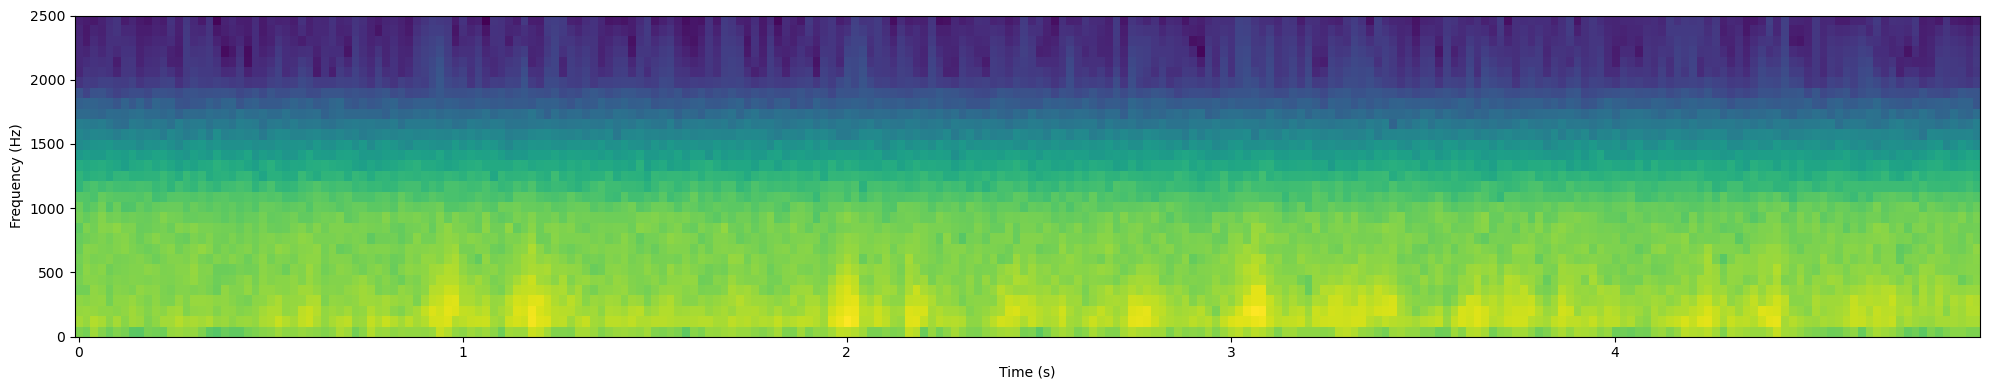

In [12]:
which = 100
T = specMatrices[which].shape[0]
hopSamples = int(20 * 5000 / 1000.0)  
timeAxis = np.arange(T) * hopSamples / 5000
freqAxis = np.linspace(0, 5000/2, 31)

plt.figure(figsize = (20, 4))
im = plt.imshow(specMatrices[which][:, 20, :].T,
                aspect = 'auto', origin = 'lower',
                extent = [timeAxis[0] - hopSamples/(2*5000), timeAxis[-1] + hopSamples/(2*5000), freqAxis[0], freqAxis[-1]])
plt.xlabel('Time (s)'); plt.ylabel('Frequency (Hz)')
plt.tight_layout(); plt.show()

In [13]:
afterMatrices = np.zeros((len(specMatrices), 409, 31, 31)) 
inputLengths = np.zeros((len(specMatrices)))
for i in range(len(specMatrices)):
    for j in range(len(specMatrices[i])):
        temp = specMatrices[i][j]
        afterMatrices[i, j] = temp
    inputLengths[i] = len(specMatrices[i])

In [14]:
class BaseDataset(Dataset):
    def __init__(self, data, labels, inputLength, targetLength):
        self.data = data 
        self.labels = labels
        self.targetLength = targetLength
        self.inputLength = inputLength

    def __getitem__(self, index):
        inputSeq = self.data[index].astype('float32')  
        targetSeq = self.labels[index]
        inputLength = int(self.inputLength[index])
        targetLength = int(self.targetLength[index])
        return inputSeq, targetSeq, inputLength, targetLength

    def __len__(self):
        return len(self.data)

In [15]:
"""
Train-validation-test split.
"""

trainFeatures = afterMatrices[:8000]
trainLabels = phonemizedLabels[:8000]
trainLabelLengths = labelLengths[:8000]
trainInputLengths = inputLengths[:8000]

valFeatures = afterMatrices[8000:9000]
valLabels = phonemizedLabels[8000:9000]
valLabelLengths = labelLengths[8000:9000]
valInputLengths = inputLengths[8000:9000]

testFeatures = afterMatrices[9000:]
testLabels = phonemizedLabels[9000:]
testLabelLengths = labelLengths[9000:]
testInputLengths = inputLengths[9000:]

In [16]:
trainDataset = BaseDataset(trainFeatures, trainLabels, trainInputLengths, trainLabelLengths)
valDataset = BaseDataset(valFeatures, valLabels, valInputLengths, valLabelLengths)
testDataset = BaseDataset(testFeatures, testLabels, testInputLengths, testLabelLengths)

trainDataloader = DataLoader(trainDataset, batch_size = 32, shuffle = True)
valDataloader = DataLoader(valDataset, batch_size = 32, shuffle = False)
testDataloader = DataLoader(testDataset, batch_size = 1, shuffle = False)

In [17]:
def trainOperation(model,  device, trainLoader, rnnOptimizer, Loss):
    model.train()
    totalLoss = 0
    for inputs, targets, inputLengths, targetLengths in trainLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputLengths, targetLengths = inputLengths.to(device), targetLengths.to(device)
        
        rnnOptimizer.zero_grad()

        outputs = model(inputs, inputLengths.cpu())
        loss = Loss(outputs, targets, inputLengths, targetLengths)
        loss.backward()
        rnnOptimizer.step()

        totalLoss += loss.item()
        
    
    return totalLoss / len(trainLoader)


def valOperation(model, device, valLoader, Loss):
    model.eval()
    totalLoss = 0
    with torch.no_grad():
        for inputs, targets, inputLengths, targetLengths in valLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputLengths, targetLengths = inputLengths.to(device), targetLengths.to(device)
            
            outputs = model(inputs, inputLengths.cpu()) 
            loss = Loss(outputs, targets, inputLengths, targetLengths)
            totalLoss += loss.item()

    return totalLoss / len(valLoader)

In [18]:
"""
To replicate the PER (phoneme error rate) for various model sizes and layers, change the variable here:
euclideanRnn.RnnNet(41, modelHiddenDimension = 25, device, numLayers = 3).to(device)
"""

dev = "cuda:0"
device = torch.device(dev)

numberEpochs = 100

model = euclideanRnn.RnnNet(41, 25, device, numLayers = 3).to(device)
numParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(numParams)
lossFunction = nn.CTCLoss(blank = 40, zero_infinity = True)
rnnOptimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-3)

6348591


In [19]:
"""
Do training.
"""
valLOSS = []
minLOSS = 100
for epoch in range(numberEpochs):
    trainLoss = trainOperation(model, device, trainDataloader, rnnOptimizer, lossFunction)
    valLoss = valOperation(model, device, valDataloader, lossFunction)
    valLOSS.append(valLoss)
    if minLOSS > valLoss:
        minLOSS = valLoss
        torch.save(model.state_dict(), "ckpts/emgSpectra/0.pt")
    print(f'Epoch: {epoch + 1}/{numberEpochs}, Training loss: {trainLoss:.4f}, Val loss: {valLoss:.4f}')
np.save("ckpts/emgSpectra/valLoss.npy", valLOSS)

Epoch: 1/100, Training loss: 3.3944, Val loss: 3.3226
Epoch: 2/100, Training loss: 3.3053, Val loss: 3.2810
Epoch: 3/100, Training loss: 3.2969, Val loss: 3.2554
Epoch: 4/100, Training loss: 3.2853, Val loss: 3.2546
Epoch: 5/100, Training loss: 3.2720, Val loss: 3.2391
Epoch: 6/100, Training loss: 3.2621, Val loss: 3.1906
Epoch: 7/100, Training loss: 3.1580, Val loss: 3.0862
Epoch: 8/100, Training loss: 3.0926, Val loss: 3.0382
Epoch: 9/100, Training loss: 3.0775, Val loss: 3.0214
Epoch: 10/100, Training loss: 3.0636, Val loss: 3.0816
Epoch: 11/100, Training loss: 3.0619, Val loss: 3.0840
Epoch: 12/100, Training loss: 3.0608, Val loss: 3.0090
Epoch: 13/100, Training loss: 3.0874, Val loss: 3.0540
Epoch: 14/100, Training loss: 3.0603, Val loss: 3.0099
Epoch: 15/100, Training loss: 3.0606, Val loss: 3.0295
Epoch: 16/100, Training loss: 3.0572, Val loss: 3.0247
Epoch: 17/100, Training loss: 3.0743, Val loss: 3.0392
Epoch: 18/100, Training loss: 3.0497, Val loss: 3.0114
Epoch: 19/100, Trai

In [20]:
np.save("ckpts/emgSpectra/valLoss.npy", valLOSS)

In [21]:
valLoss = np.load("ckpts/emgSpectra/valLoss.npy")
print(np.min(valLoss))
print(np.argmin(valLoss))
epoch = np.argmin(valLoss)

2.9918632432818413
67


In [22]:
def testOperation(model, device, testLoader, Loss):
    model.eval()
    totalLoss = 0
    Outputs = []
    with torch.no_grad():
        for inputs, targets, inputLengths, targetLengths in testLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputLengths, targetLengths = inputLengths.to(device), targetLengths.to(device)
            
            outputs = model(inputs, inputLengths.cpu()) 

            loss = Loss(outputs, targets, inputLengths, targetLengths)
            totalLoss += loss.item()
            Outputs.append(outputs.transpose(0, 1))

    return Outputs, totalLoss / len(testLoader)

In [23]:
"""
Simple beam-search algorithm.
"""

def ctcPrefixBeamSearch(
    logProbs,
    testLen = None,
    beamSize = 5,
    blank = 40,
    topk = None,
    allowDoubles = True,
):
    
    lp = np.asarray(logProbs)
    Ttotal, V = lp.shape
    T = Ttotal if testLen is None else int(min(testLen, Ttotal))

    beams = {(): (0.0, -np.inf)}

    def add(store, seq, addPb, addPnb):
        if seq in store:
            pb, pnb = store[seq]
            if addPb  != -np.inf: pb  = np.logaddexp(pb,  addPb)
            if addPnb != -np.inf: pnb = np.logaddexp(pnb, addPnb)
            store[seq] = (pb, pnb)
        else:
            store[seq] = (addPb, addPnb)

    for t in range(T):
        row = lp[t] 
        new = {}

        if topk is not None and topk < V:
            cand = np.argpartition(row, -topk)[-topk:]
            if blank not in cand:
                worstIdx = cand[np.argmin(row[cand])]
                cand[cand == worstIdx] = blank
        else:
            cand = range(V)

        for seq, (pb, pnb) in beams.items():
            add(new, seq, np.logaddexp(pb, pnb) + row[blank], -np.inf)

            last = seq[-1] if seq else None

            for c in cand:
                if c == blank:
                    continue
                pC = row[c]

                if c == last:
            
                    add(new, seq, -np.inf, pnb + pC)

                    if allowDoubles:
                        add(new, seq + (c,), -np.inf, pb + pC)
                else:
                    add(new, seq + (c,), -np.inf, np.logaddexp(pb, pnb) + pC)

        if len(new) > beamSize:
            items = sorted(new.items(),
                           key = lambda kv: np.logaddexp(*kv[1]),
                           reverse = True)[:beamSize]
            beams = dict(items)
        else:
            beams = new

    bestSeq = max(beams.items(), key = lambda kv: np.logaddexp(*kv[1]))[0]
    return bestSeq

def findClosestTranscription(decodedTranscript, phoneticTranscription):
    
    dist = Levenshtein.distance(decodedTranscript, phoneticTranscription)

    return dist

In [24]:
#modelWeight = torch.load("DATA/ckptsLargeVocab/ckptSpectrogram.pt", weights_only = True)
modelWeight = torch.load("ckpts/emgSpectra/" + str(0)  + '.pt', weights_only = True)
model.load_state_dict(modelWeight)
output, testLoss = testOperation(model, device, testDataloader, lossFunction)

print("TEST LOSS: ", testLoss)

TEST LOSS:  2.9971692364833076


In [25]:
outs = []
for o in output:
    for oo in o:
        outs.append(oo)

In [26]:
print(len(outs))
print(outs[0].shape)

1970
torch.Size([147, 41])


In [27]:
LEVS = []
decodedOut = []
for i in range(1970):
    print(i)
    decodedSymbols = ctcPrefixBeamSearch(outs[i].cpu().numpy(), testInputLengths[i], beamSize = 50) 
    phoneOut = []
    for j in range(len(decodedSymbols)):
        phoneOut.append(PHONE_DEF[decodedSymbols[j]])
    decodedOut.append(phoneOut)

levs = []
phoneLENGTHS = []
for i in range(len(decodedOut)):
    phoneLENGTHS.append(len(phonemizedSentences[9000 + i]))
    levs.append(findClosestTranscription(decodedOut[i], phonemizedSentences[9000 + i]))
LEVS.append(np.mean(levs))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
print("Mean length of sentences: ", np.mean(phoneLENGTHS))
print("Mean phoneme errors (insertion errors + deletion errors + substitution errors): ", np.mean(levs))
print("Percent phoneme error: ", np.sum(levs)/np.sum(phoneLENGTHS))

Mean length of sentences:  24.543654822335025
Mean phoneme errors (insertion errors + deletion errors + substitution errors):  19.353807106598985
Percent phoneme error:  0.788546255506608


In [29]:
"""
Sort the decoded sentences from best-to-worst. Display 100 best decoded sentences.
"""

indices = np.argsort(np.array(levs)/np.array(phoneLENGTHS))
print(indices[:100])

[1357 1478  487  620  806  250 1674  627  810 1276  714   41 1406  619
 1218 1189  587 1591 1275  311  133  228 1244 1123  277 1077 1231  454
 1132  808 1619  145  882 1557  256  261  814 1109   59  962   98  105
   76  881  815  777 1148 1779  195  173  976  581  452 1098  151 1418
 1399  854  442 1713 1899 1342  947 1168 1768 1255  550  761 1526  430
   29   36  770 1222  663 1492 1969  697  248 1227 1551 1777  713  336
 1533  662  238 1343  893  493 1047 1705  668 1423 1905   78  648 1496
 1381  970]


In [36]:
"""
Visualize decoded sentences.
"""

which = 806
print("Decoded phoneme sequence: ", decodedOut[which])
print("Ground truth phoneme sequence: ", phonemizedSentences[9000 + which])
print("Ground truth label: ", LABELS[9000 + which])
print(" ")
print("Levenshtein distance between decoded and ground truth sequence: ", Levenshtein.distance(decodedOut[which], phonemizedSentences[9000 + which]))
print("Length of ground truth sequence: ", len(phonemizedSentences[9000 + which]))

Decoded phoneme sequence:  ['IH', ' ', 'IH', ' ', 'AH', ' ', ' ', ' ', 'T']
Ground truth phoneme sequence:  ['IH', 'T', 'S', ' ', 'G', 'OW', 'IH', 'NG', ' ', 'T', 'UW', ' ', 'B', 'IY', ' ', 'HH', 'AA', 'R', 'D', ' ', 'T', 'UW']
Ground truth label:  its going to be hard to
 
Levenshtein distance between decoded and ground truth sequence:  14
Length of ground truth sequence:  22
